In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial.distance import cdist
from skimage import measure
from matplotlib import pyplot as plt
import os
import tifffile
from tqdm import tqdm
from typing import List, Set, Tuple

In [2]:
data_raw = pd.read_csv(os.path.join("../../data/magnifications_matching",
                         f"20x_raw.field_thr.all.tsv"), sep="\t")

In [3]:
def group_dots(ddf: pd.DataFrame) -> Tuple[List[Set[int]], Set[int]]:
    grouped: List[Set[int]] = []
    added: Set[int] = set()
    for dot_id in set(ddf["A"].values):
        if not dot_id in added:
            selected = ddf.loc[ddf["A"] == dot_id, "B"].values
            for selected_id in selected:
                assert selected_id not in added
                added.add(selected_id)
            grouped.append(set(selected))
    return (grouped, added)

def clean_df(field_data: pd.DataFrame, added: Set[int], grouped: List[Set[int]]) -> pd.DataFrame:
    cleaned_df_list: List[pd.DataFrame] = [field_data.iloc[[i for i in range(field_data.shape[0]) if i not in added], :]]
    for group in grouped:
        ids = list(group)
        if 1 == len(group):
            selected_id = ids[0]
        else:
            selected_id = ids[np.argmax(field_data.loc[ids, "SNR2"])]
            #print(f"Discarding {len(ids)-1} dots.")
        cleaned_df_list.append(field_data.iloc[[selected_id], :])
    return pd.concat(cleaned_df_list)


In [4]:
cleaned_df_list: List[pd.DataFrame] = []
for current_field_id in tqdm(set(data_raw["sid"].values)):
    field_data = data_raw.loc[current_field_id == data_raw["sid"], ].reset_index()
    coords = data_raw.loc[current_field_id == data_raw["sid"], ("x", "y")]
    d = cdist(coords, coords)
    ddf = pd.DataFrame(np.array(np.where(d <= .5)).transpose(), columns=("A", "B"))
    grouped, added = group_dots(ddf)
    cleaned_df_list.append(clean_df(field_data, added, grouped))

cleaned_df = pd.concat(cleaned_df_list).reset_index()

100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


In [5]:
cleaned_df

,level_0,index,sid,nid,size,dilated_size,scaling,magnification,image_type,Channel,...,x,y,z,Value,FWHM,SNR,NSNR,Label,SNR2,Value2
0,0,0,1,94,3970,7457,1.0,20x,raw,a647,...,404.044,15.908,56.020,0.931,3.925,13.147,-1.000,0,6.448689,0.931
1,2,2,1,94,3970,7457,1.0,20x,raw,a647,...,404.000,17.027,59.180,0.823,4.148,14.284,-1.000,0,9.761700,0.823
2,3,3,1,111,5754,12212,1.0,20x,raw,a647,...,413.027,579.941,53.188,0.808,2.856,14.646,-1.000,0,15.489744,0.808
3,4,4,1,84,7434,14410,1.0,20x,raw,a647,...,320.987,49.980,55.004,0.613,1.729,14.993,1.658,0,10.577747,0.613
4,5,5,1,7,8570,15948,1.0,20x,raw,a647,...,80.956,257.054,55.239,0.575,2.589,7.825,-1.000,0,6.928869,0.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11185,428,15372,7,130,7953,13126,1.0,20x,raw,a647,...,403.019,168.955,48.011,0.096,3.811,4.735,-1.000,0,4.343068,0.096
11186,429,15373,7,154,4829,9065,1.0,20x,raw,a647,...,496.019,181.910,57.009,0.096,2.910,3.152,-1.000,0,2.892631,0.096
11187,430,15374,7,91,8994,16058,1.0,20x,raw,a647,...,276.043,119.066,53.006,0.096,3.566,4.377,-1.000,0,3.565668,0.096
11188,431,15375,7,146,5982,9533,1.0,20x,raw,a647,...,466.980,338.996,50.020,0.096,1.386,4.998,1.028,0,4.541584,0.096


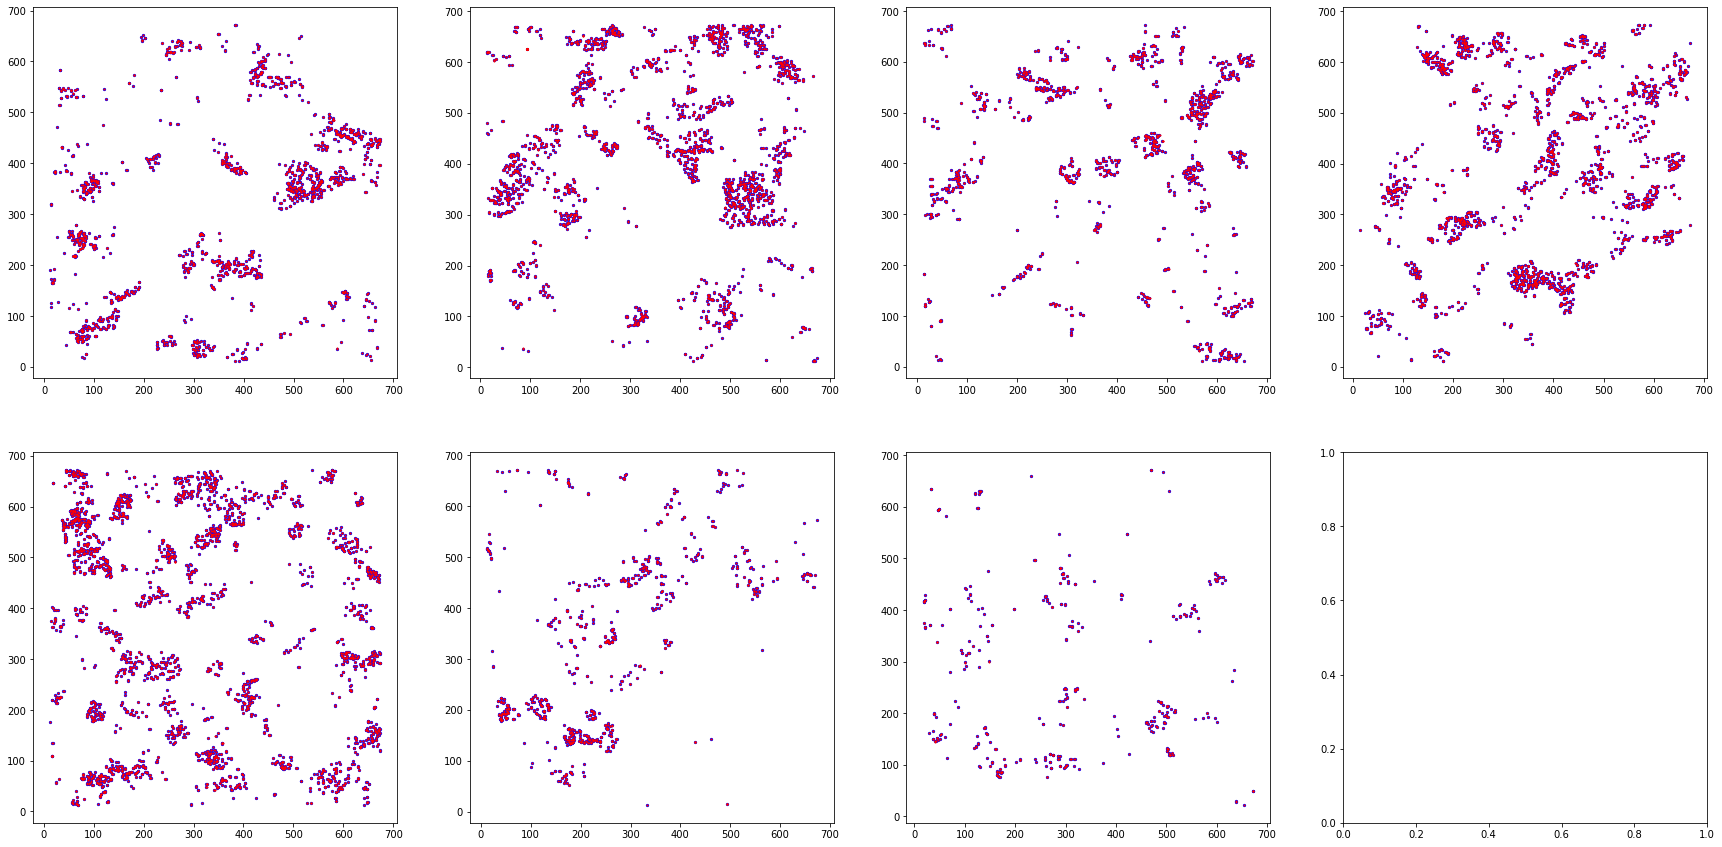

In [6]:
fig, ax = plt.subplots(figsize=(30, 15), nrows=2, ncols=4)
for i in range(7):
    ax[i//4, i%4].scatter(
        x=cleaned_df.loc[i+1 == cleaned_df["sid"], "x"],
        y=cleaned_df.loc[i+1 == cleaned_df["sid"], "y"],
        facecolors="blue", s=5)
    ax[i//4, i%4].scatter(
        x=data_raw.loc[i+1 == data_raw["sid"], "x"],
        y=data_raw.loc[i+1 == data_raw["sid"], "y"],
        facecolors="red", s=1)

In [7]:
n_dots_raw = data_raw.shape[0]
n_dots_clean = cleaned_df.shape[0]
print(f"Total: {n_dots_clean}/{n_dots_raw} ({n_dots_clean/n_dots_raw*100:.2f}%) (-{n_dots_raw-n_dots_clean})")
for i in range(1, 8):
    n_dots_raw = np.sum(data_raw["sid"] == i)
    n_dots_clean = np.sum(cleaned_df["sid"] == i)
    print(f"Field #{i}: {n_dots_clean}/{n_dots_raw} ({n_dots_clean/n_dots_raw*100:.2f}%) (-{n_dots_raw-n_dots_clean})")

Total: 11190/15377 (72.77%) (-4187)
Field #1: 1554/2203 (70.54%) (-649)
Field #2: 2249/3098 (72.60%) (-849)
Field #3: 1291/1784 (72.37%) (-493)
Field #4: 2201/3009 (73.15%) (-808)
Field #5: 2770/3814 (72.63%) (-1044)
Field #6: 769/1036 (74.23%) (-267)
Field #7: 356/433 (82.22%) (-77)


In [8]:
cleaned_df.to_csv(os.path.join("../../data/magnifications_matching", 
                                   f"20x_raw.field_thr.cleaned.all.tsv"
                                  ), sep="\t", index=False)

In [9]:
cleaned_df.loc[cleaned_df["x"] == 11.928]

,level_0,index,sid,nid,size,dilated_size,scaling,magnification,image_type,Channel,...,x,y,z,Value,FWHM,SNR,NSNR,Label,SNR2,Value2
10215,197,14105,6,5,1674,5300,1.0,20x,raw,a647,...,11.928,515.867,49.036,0.169,2.871,1.155,-1.0,0,1.739411,0.169


In [10]:
data_raw.loc[data_raw["x"] == 11.928]

,sid,nid,size,dilated_size,scaling,magnification,image_type,Channel,Nuclei,x,y,z,Value,FWHM,SNR,NSNR,Label,SNR2,Value2
14105,6,5,1674,5300,1.0,20x,raw,a647,0,11.928,515.867,49.036,0.169,2.871,1.155,-1.0,0,1.739411,0.169
